In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from data_load import image_data_loader

In [2]:
X, y = image_data_loader()

In [3]:
len(X)

17886

In [4]:
X = X / 255.0

In [5]:
np.random.shuffle(X)

In [6]:
X.shape

(17886, 255, 255)

In [7]:
X = np.expand_dims(X, axis=3)

In [8]:
X.shape

(17886, 255, 255, 1)

In [9]:
import matplotlib.pyplot as plt

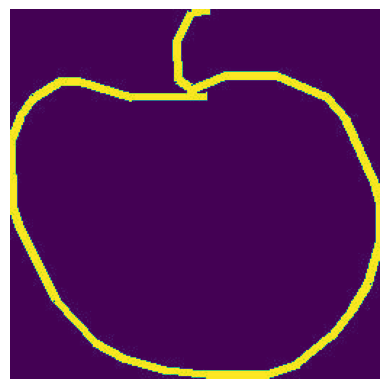

In [10]:
plt.axis('off')
plt.imshow(X[0]);

In [11]:
X = np.array(list(map(lambda x: tf.image.resize(x, (112, 112)), X)))

In [12]:
X.shape

(17886, 112, 112, 1)

In [13]:
train_ratio = 0.95
data_size = X.shape[0]

In [14]:
X_train = X[:int(data_size * train_ratio)]
X_test = X[int(data_size * train_ratio):]

In [15]:
print(X_train.shape)
print(X_test.shape)

(16991, 112, 112, 1)
(895, 112, 112, 1)


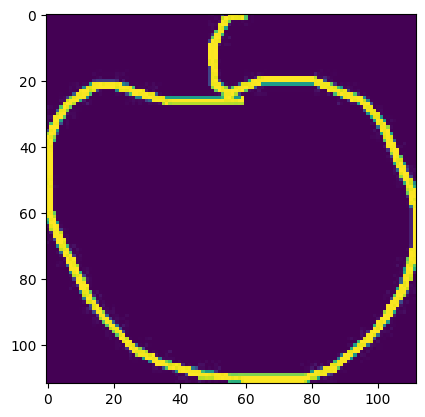

In [16]:
plt.imshow(X_train[0])

# **NOW LET'S DEFINE MODEL**

In [107]:
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
import tensorflow.keras.backend as K
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

In [108]:
img_shape = X_train.shape[1:]
img_shape

(112, 112, 1)

In [109]:
latent_dimensions = 3

In [110]:
input_image = Input(shape=img_shape)

x = layers.RandomFlip()(input_image)
x = layers.RandomZoom((0.2, 0.3))(x)
x = layers.Conv2D(8, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(16, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(32, kernel_size=(3, 3), padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

conv_shape = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

z_sigma = layers.Dense(latent_dimensions)(x)
z_mu = layers.Dense(latent_dimensions)(x)

def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_sigma)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

z = layers.Lambda(sample_z, output_shape=(latent_dimensions,))([z_sigma, z_mu])


In [111]:
encoder = Model(input_image, [z_mu, z_sigma, z])

In [112]:
encoder.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 random_flip_5 (RandomFlip)  (None, 112, 112, 1)          0         ['input_10[0][0]']            
                                                                                                  
 random_zoom_2 (RandomZoom)  (None, 112, 112, 1)          0         ['random_flip_5[0][0]']       
                                                                                                  
 conv2d_12 (Conv2D)          (None, 112, 112, 8)          80        ['random_zoom_2[0][0]']       
                                                                                           

In [113]:
decoder_input = Input(shape=(latent_dimensions,))
x = layers.Dense(32, activation='relu')(decoder_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3])(x)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = layers.Conv2DTranspose(8, kernel_size=(3, 3), padding='same', strides=(2, 2))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', strides=(2, 2))(x)
x = layers.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', strides=(2, 2))(x)

output = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

In [114]:
decoder = Model(decoder_input, output)

In [115]:
decoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_36 (Dense)            (None, 32)                128       
                                                                 
 dense_37 (Dense)            (None, 128)               4224      
                                                                 
 dense_38 (Dense)            (None, 256)               33024     
                                                                 
 dense_39 (Dense)            (None, 256)               65792     
                                                                 
 dense_40 (Dense)            (None, 256)               65792     
                                                                 
 dense_41 (Dense)            (None, 6272)              161

In [116]:
z_decoded = decoder(z)
z_decoded

<tf.Tensor 'model_13/conv2d_15/Sigmoid:0' shape=(?, 112, 112, 1) dtype=float32>

In [117]:
class LossLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [118]:
y = LossLayer()([input_image, z_decoded])
y

<tf.Tensor 'loss_layer_4/loss_layer_4/Identity:0' shape=(?, 112, 112, 1) dtype=float32>

In [119]:
vae = Model(input_image, y)

In [120]:
vae.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 random_flip_5 (RandomFlip)  (None, 112, 112, 1)          0         ['input_10[0][0]']            
                                                                                                  
 random_zoom_2 (RandomZoom)  (None, 112, 112, 1)          0         ['random_flip_5[0][0]']       
                                                                                                  
 conv2d_12 (Conv2D)          (None, 112, 112, 8)          80        ['random_zoom_2[0][0]']       
                                                                                           

In [121]:
vae.compile(
    optimizer='adam',
    loss=None
)

In [122]:
hist = vae.fit(
    X_train, None,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, None)
)

Train on 16991 samples, validate on 895 samples
Epoch 1/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.3451 - val_loss: 0.2897
Epoch 2/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2907 - val_loss: 0.2824
Epoch 3/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2828 - val_loss: 0.2767
Epoch 4/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2782 - val_loss: 0.2725
Epoch 5/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2744 - val_loss: 0.2689
Epoch 6/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2716 - val_loss: 0.2662
Epoch 7/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2694 - val_loss: 0.2643
Epoch 8/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2680 - val_loss: 0.2632
Epoch 9/15
16991/16991 [==============================] - 27s 2ms/sample - loss: 0.2670 - val_lo

In [123]:
preds = vae.predict(X_test)

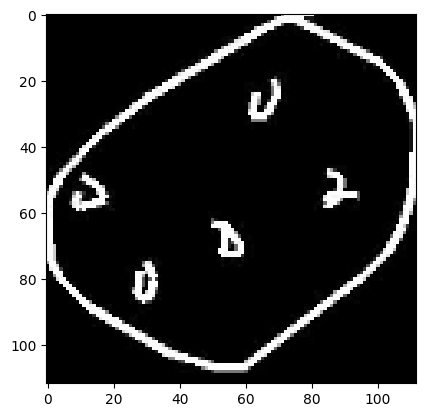

In [124]:
plt.imshow(preds[0], cmap='gray')

In [125]:
def vae_generate_images(new_to_show=10):
    random_codes = np.random.normal(size=(new_to_show, 3))
    new_faces = decoder.predict(np.array(random_codes))

    fig = plt.figure(figsize=(30, 15))

    for i in range(new_to_show):
        ax = fig.add_subplot(6, 10, i+1)
        ax.imshow(new_faces[i], cmap='gray')
        ax.axis('off')
    plt.show()

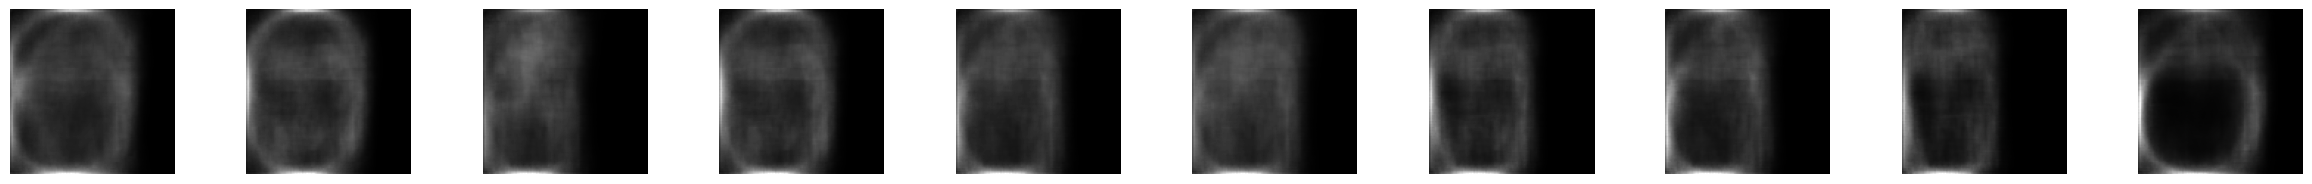

In [126]:
vae_generate_images(10)

It's too foggy...<br>
I'll use GANs for this<br>
I've wasted 4 hours of my life on tuning it...